In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, RandomBrightness, RandomZoom, RandomContrast, RandomTranslation, Dropout, BatchNormalization, AvgPool2D, MaxPool2D

2023-10-28 21:13:45.132649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 21:13:45.614305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
x=np.load('Xtrain_Classification2.npy')
y=np.load('ytrain_Classification2.npy')
first_time = True
print(len(np.where(y==0)[0])/len(y))
print(len(np.where(y==1)[0])/len(y))
print(len(np.where(y==2)[0])/len(y))
print(len(np.where(y==3)[0])/len(y))
print(len(np.where(y==4)[0])/len(y))
print(len(np.where(y==5)[0])/len(y))

0.5044689058236899
0.08373318280176875
0.010913538432590084
0.21685953523379434
0.09314140558848434
0.09088343211967259


In [93]:
METRICS = [tf.keras.metrics.Recall(class_id=i, name=f'recall_{i}') for i in range(3)]

class TrainBalancedAccuracyCallback(tf.keras.callbacks.Callback):

    def __init__(self, **kargs):
        super(TrainBalancedAccuracyCallback, self).__init__(**kargs)

    def on_epoch_end(self, epoch, logs={}):
        logs['train_balacc'] = sum([logs['recall_{}'.format(i)] for i in range(3)]) / 3
        print(' train_balacc', logs['train_balacc'])

class ValBalancedAccuracyCallback(tf.keras.callbacks.Callback):

    def __init__(self, **kargs):
        super(ValBalancedAccuracyCallback, self).__init__(**kargs)

    def on_epoch_end(self, epoch, logs={}):

        logs['val_balacc'] = sum([logs['val_recall_{}'.format(i)] for i in range(3)]) / 3
        print('val_balacc', logs['val_balacc'])

In [4]:
def split_classes(x, y):
    train_images = (x).astype('float32')/255.0
    nevu_images = train_images[y == 0]
    melanoma_images = train_images[y == 1]
    vascular_images = train_images[y == 2]
    granulocytes_images = train_images[y == 3]
    basophils_images = train_images[y == 4]
    lymphocytes_images = train_images[y == 5]

    y_nevu = y[y == 0]
    y_mela = y[y == 1]
    y_vasc = y[y == 2]
    y_gran = y[y == 3]
    y_baso = y[y == 4]
    y_lymp = y[y == 5]

    num_nevu = len((y_nevu))
    num_mela = len((y_mela))
    num_vasc = len((y_vasc))
    num_gran = len((y_gran))
    num_baso = len((y_baso))
    num_lymp = len((y_lymp))

    nevu_images = np.reshape(nevu_images, (num_nevu,28,28,3))
    melanoma_images = np.reshape(melanoma_images, (num_mela,28,28,3))
    vascular_images = np.reshape(vascular_images, (num_vasc,28,28,3))
    granulocytes_images = np.reshape(granulocytes_images, (num_gran,28,28,3))
    basophils_images = np.reshape(basophils_images, (num_baso,28,28,3))
    lymphocytes_images = np.reshape(lymphocytes_images, (num_lymp,28,28,3))

    return nevu_images, melanoma_images, vascular_images, granulocytes_images, basophils_images, lymphocytes_images, y_nevu, y_mela, y_vasc, y_gran, y_baso, y_lymp

def augment_melanoma(melanoma_images, X_mela, y_mela, num_nevu_train):
  bright_data = models.Sequential([
    RandomBrightness(factor=0.35, value_range=[0.0, 1.0]),
  ])
  zoom_data = models.Sequential([
    RandomZoom(height_factor=0.25, fill_mode='nearest'),
  ])
  translation_data = models.Sequential([
    RandomTranslation(height_factor=0.25, width_factor=0.2, fill_mode='nearest'),
  ])
  augmented_images = tf.image.flip_left_right(melanoma_images)
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = bright_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = zoom_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = translation_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))  
  augmented_images = tf.image.flip_up_down(melanoma_images)
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))

  dif = len(X_mela) - num_nevu_train
  return X_mela[:len(X_mela) - dif], y_mela[:len(X_mela) - dif]

def augment_vascular(vascular_images, X_vasc, y_vasc, num_nevu_train):
  zoom_data = models.Sequential([
    RandomZoom(height_factor=0.25, fill_mode='nearest'),
  ])
  bright_data = models.Sequential([
    RandomBrightness(factor=0.35, value_range=[0.0, 1.0]),
  ])
  translation_data = models.Sequential([
    RandomTranslation(height_factor=0.25, width_factor=0.2, fill_mode='nearest'),
  ])
  augmented_images = tf.image.flip_left_right(vascular_images)
  X_vasc = np.vstack([X_vasc, augmented_images])
  y_vasc = np.hstack((y_vasc, 2*np.ones(len(augmented_images,))))
  augmented_images = zoom_data(X_vasc).numpy()
  X_vasc = np.vstack([X_vasc, augmented_images])
  y_vasc = np.hstack((y_vasc, 2*np.ones(len(augmented_images,))))
  augmented_images = bright_data(X_vasc).numpy()
  X_vasc = np.vstack([X_vasc, augmented_images])
  y_vasc = np.hstack((y_vasc, 2*np.ones(len(augmented_images,))))
  augmented_images = translation_data(X_vasc).numpy()
  X_vasc = np.vstack([X_vasc, augmented_images])
  y_vasc = np.hstack((y_vasc, 2*np.ones(len(augmented_images,))))  
  augmented_images = tf.image.rot90(X_vasc)
  X_vasc = np.vstack([X_vasc, augmented_images])
  y_vasc = np.hstack((y_vasc, 2*np.ones(len(augmented_images,))))
  augmented_images = tf.image.flip_up_down(X_vasc)
  X_vasc = np.vstack([X_vasc, augmented_images])
  y_vasc = np.hstack((y_vasc, 2*np.ones(len(augmented_images,))))
  
  dif = len(X_vasc) - num_nevu_train
  return X_vasc[:len(X_vasc) - dif], y_vasc[:len(X_vasc) - dif]

def augment_granulocytes(granulocytes_images, X_gran, y_gran, num_nevu_train):
  augmented_images = tf.image.flip_left_right(granulocytes_images)
  X_gran = np.vstack([X_gran, augmented_images])
  y_gran = np.hstack((y_gran, 3*np.ones(len(augmented_images,))))
  augmented_images = tf.image.flip_up_down(granulocytes_images)
  X_gran = np.vstack([X_gran, augmented_images])
  y_gran = np.hstack((y_gran, 3*np.ones(len(augmented_images,))))

  dif = len(X_gran) - num_nevu_train
  return X_gran[:len(X_gran) - dif], y_gran[:len(X_gran) - dif]

def augment_basophils(basophils_images, X_baso, y_baso, num_nevu_train):
  zoom_data = models.Sequential([
    RandomZoom(height_factor=0.25, fill_mode='nearest'),
  ])
  bright_data = models.Sequential([
    RandomBrightness(factor=0.35, value_range=[0.0, 1.0]),
  ])
  augmented_images = tf.image.flip_left_right(basophils_images)
  X_baso = np.vstack([X_baso, augmented_images])
  y_baso = np.hstack((y_baso, 4*np.ones(len(augmented_images,))))
  augmented_images = zoom_data(basophils_images).numpy()
  X_baso = np.vstack([X_baso, augmented_images])
  y_baso = np.hstack((y_baso, 4*np.ones(len(augmented_images,))))
  augmented_images = bright_data(basophils_images).numpy()
  X_baso = np.vstack([X_baso, augmented_images])
  y_baso = np.hstack((y_baso, 4*np.ones(len(augmented_images,))))
  augmented_images = tf.image.flip_up_down(basophils_images)
  X_baso = np.vstack([X_baso, augmented_images])
  y_baso = np.hstack((y_baso, 4*np.ones(len(augmented_images,))))

  dif = len(X_baso) - num_nevu_train

  return X_baso[:len(X_baso) - dif], y_baso[:len(X_baso) - dif]

def augment_lymphocytes(lymphocytes_images, X_lymp, y_lymp, num_nevu_train):
  zoom_data = models.Sequential([
    RandomZoom(height_factor=0.25, fill_mode='nearest'),
  ])
  bright_data = models.Sequential([
    RandomBrightness(factor=0.35, value_range=[0.0, 1.0]),
  ])  
  augmented_images = tf.image.flip_left_right(lymphocytes_images)
  X_lymp = np.vstack([X_lymp, augmented_images])
  y_lymp = np.hstack((y_lymp, 5*np.ones(len(augmented_images,))))
  augmented_images = zoom_data(lymphocytes_images).numpy()
  X_lymp = np.vstack([X_lymp, augmented_images])
  y_lymp = np.hstack((y_lymp, 5*np.ones(len(augmented_images,))))
  augmented_images = bright_data(lymphocytes_images).numpy()
  X_lymp = np.vstack([X_lymp, augmented_images])
  y_lymp = np.hstack((y_lymp, 5*np.ones(len(augmented_images,))))
  augmented_images = tf.image.flip_up_down(lymphocytes_images)
  X_lymp = np.vstack([X_lymp, augmented_images])
  y_lymp = np.hstack((y_lymp, 5*np.ones(len(augmented_images,))))

  dif = len(X_lymp) - num_nevu_train

  return X_lymp[:len(X_lymp) - dif], y_lymp[:len(X_lymp) - dif]

def augmentate_all_data(all_images, all_labels):
  all_labels_aug = np.empty((1,), dtype=np.int8)
  all_images_aug = np.empty((1,28,28,3), dtype=np.float32)

  # contrast_data = models.Sequential([
  #   RandomContrast(factor=0.2),
  # ])
  # augmented_images = contrast_data(all_images).numpy()
  # all_images_aug = np.vstack([all_images_aug, augmented_images])
  # all_labels_aug = np.hstack((all_labels_aug, all_labels))
  # rotated_180 = tf.image.rot90((all_images), k=2)
  # all_images_aug = np.vstack([all_images_aug, rotated_180])
  # all_labels_aug = np.hstack((all_labels_aug, all_labels))
  # rotated_270 = tf.image.rot90((all_images), k=3)
  # all_images_aug = np.vstack([all_images_aug, rotated_270])
  # all_labels_aug = np.hstack((all_labels_aug, all_labels))

  zoom_data = models.Sequential([
    RandomZoom(height_factor=0.25, fill_mode='nearest'),
  ])
  bright_data = models.Sequential([
    RandomBrightness(factor=0.35, value_range=[0.0, 1.0]),
  ])
  translation_data = models.Sequential([
    RandomTranslation(height_factor=0.25, width_factor=0.2, fill_mode='nearest'),
  ])
  augmented_images = tf.image.flip_left_right(all_images)
  all_images_aug = np.vstack([all_images_aug, augmented_images])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  augmented_images = zoom_data(all_images).numpy()
  all_images_aug = np.vstack([all_images_aug, augmented_images])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  augmented_images = bright_data(all_images).numpy()
  all_images_aug = np.vstack([all_images_aug, augmented_images])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  augmented_images = translation_data(all_images).numpy()
  all_images_aug = np.vstack([all_images_aug, augmented_images])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))  
  augmented_images = tf.image.flip_up_down(all_images)
  all_images_aug = np.vstack([all_images_aug, augmented_images])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))

  all_images_aug = all_images_aug[1:]
  all_labels_aug = all_labels_aug[1:]

  return all_images_aug, all_labels_aug

In [5]:
def display_model_data(history_cnn, prev_history):
    val_balanced_acc = history_cnn.history['val_balacc']
    prev_val_balanced_acc = prev_history.history['val_balacc']

    if len(val_balanced_acc) > len(prev_val_balanced_acc):
        epochs = range(1, len(prev_val_balanced_acc) + 1)
    else:
        epochs = range(1, len(val_balanced_acc) + 1)
    plt.figure(figsize=(12,6))
    plt.plot(epochs, val_balanced_acc[:max(epochs)], 'r-', label='This CNN')
    plt.plot(epochs, prev_val_balanced_acc[:max(epochs)], 'b', label='Prev CNN'),
    plt.title('Balanced Validation Accuracy')
    plt.legend()
    plt.show()

    acc = history_cnn.history['accuracy']
    val_acc = history_cnn.history['val_accuracy']
    prev_acc = prev_history.history['accuracy']
    prev_val_acc = prev_history.history['val_accuracy']

    loss = history_cnn.history['loss']
    val_loss = history_cnn.history['val_loss']
    prev_loss = prev_history.history['loss']
    prev_val_loss = prev_history.history['val_loss']

    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.plot(epochs, acc[:max(epochs)], 'ro', label='Training acc')
    ax1.plot(epochs, val_acc[:max(epochs)], 'r', label='Validation acc')
    ax1.set_title('This CNN')
    ax1.legend()
    # ax1.set_xlim([0,300])
    ax1.set_ylim([0.4,1])
    ax2.plot(epochs, prev_acc[:max(epochs)], 'bo', label='Training acc')
    ax2.plot(epochs, prev_val_acc[:max(epochs)], 'b', label='Validation acc')
    ax2.set_title('Prev CNN')
    ax2.legend()
    # ax2.set_xlim([0,300])
    ax2.set_ylim([0.4,1])
    fig1.suptitle('Training and Validation Accuracy')

    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,6))
    ax3.plot(epochs, loss[:max(epochs)], 'ro', label='Training loss')
    ax3.plot(epochs, val_loss[:max(epochs)], 'r', label='Validation loss')
    ax3.set_title('This CNN')
    ax3.legend()
    # ax3.set_xlim([0,300])
    ax3.set_ylim([0,4])
    ax4.plot(epochs, prev_loss[:max(epochs)], 'bo', label='Training loss')
    ax4.plot(epochs, prev_val_loss[:max(epochs)], 'b', label='Validation loss')
    ax4.set_title('Prev CNN')
    ax4.legend()
    # ax4.set_xlim([0,300])
    ax4.set_ylim([0,4])
    fig2.suptitle('Training and Validation Loss')

In [6]:
def create_ds_splitter(kernel_size):
    model_cnn = models.Sequential()
    model_cnn.add(Conv2D(16, kernel_size, activation='relu', input_shape=(28, 28, 3)))
    model_cnn.add(MaxPool2D(pool_size=(2, 2)))
    model_cnn.add(Conv2D(32, kernel_size, activation='relu', input_shape=(28, 28, 3)))
    model_cnn.add(MaxPool2D(pool_size=(2, 2)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(800, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(2, activation='softmax'))
    model_cnn.summary()

    model_cnn.compile(optimizer = optimizers.Adam(learning_rate=1e-3),
                loss = 'categorical_crossentropy',
                metrics=[METRICS, ['accuracy']])
    return model_cnn

def create_CNN_model(kernel_size):
    model_cnn = models.Sequential()
    model_cnn.add(Conv2D(32, kernel_size, padding='same', activation='relu', input_shape=(28, 28, 3)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(32, kernel_size, activation='relu'))
    model_cnn.add(AvgPool2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Conv2D(64, kernel_size, padding='same', activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(64, kernel_size, activation='relu'))
    model_cnn.add(AvgPool2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(1600, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(3, activation='softmax'))
    model_cnn.summary()

    model_cnn.compile(optimizer = optimizers.Adam(learning_rate=1e-3),
                loss = 'categorical_crossentropy',
                metrics=[METRICS,['accuracy']])
    return model_cnn

In [151]:
nevu_images, melanoma_images, vascular_images, granulocytes_images, basophils_images, lymphocytes_images, y_nevu, y_mela, y_vasc, y_gran, y_baso, y_lymp = split_classes(x, y)

X_nevu_train, X_nevu_val, y_nevu_train, y_nevu_val = train_test_split(nevu_images, y_nevu, test_size=0.2, random_state=0)
X_mela_train, X_mela_val, y_mela_train, y_mela_val = train_test_split(melanoma_images, y_mela, test_size=0.2, random_state=0)
X_vasc_train, X_vasc_val, y_vasc_train, y_vasc_val = train_test_split(vascular_images, y_vasc, test_size=0.2, random_state=0)
X_gran_train, X_gran_val, y_gran_train, y_gran_val = train_test_split(granulocytes_images, y_gran, test_size=0.2, random_state=0)
X_baso_train, X_baso_val, y_baso_train, y_baso_val = train_test_split(basophils_images, y_baso, test_size=0.2, random_state=0)
X_lymp_train, X_lymp_val, y_lymp_train, y_lymp_val = train_test_split(lymphocytes_images, y_lymp, test_size=0.2, random_state=0)

X_mela_train, y_mela_train = augment_melanoma(melanoma_images, X_mela_train, y_mela_train, len(X_nevu_train))
X_vasc_train, y_vasc_train = augment_vascular(vascular_images, X_vasc_train, y_vasc_train, len(X_nevu_train))
X_gran_train, y_gran_train = augment_granulocytes(granulocytes_images, X_gran_train, y_gran_train, len(X_nevu_train))
X_baso_train, y_baso_train = augment_basophils(basophils_images, X_baso_train, y_baso_train, len(X_nevu_train))
X_lymp_train, y_lymp_train = augment_lymphocytes(lymphocytes_images, X_lymp_train, y_lymp_train, len(X_nevu_train))

X_train = np.vstack((X_lymp_train, X_baso_train, X_gran_train, X_vasc_train, X_mela_train, X_nevu_train))
X_val = np.vstack((X_lymp_val, X_baso_val, X_gran_val, X_vasc_val, X_mela_val, X_nevu_val))
y_train = np.hstack((y_lymp_train, y_baso_train, y_gran_train, y_vasc_train, y_mela_train, y_nevu_train))
y_val = np.hstack((y_lymp_val, y_baso_val, y_gran_val, y_vasc_val, y_mela_val, y_nevu_val)) 

# X_train, y_train = augmentate_all_data(X_train, y_train)
X_val, y_val = augmentate_all_data(X_val, y_val)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

#print(f"Percentage of Melanoma in val data is {len(np.where(y_val==1)[0])/len(y_val)*100:2.2f}%")
prop_0 = len(np.where(y_train==0)[0])/len(y_train)
prop_1 = len(np.where(y_train==1)[0])/len(y_train)
prop_2 = len(np.where(y_train==2)[0])/len(y_train)
prop_3 = len(np.where(y_train==3)[0])/len(y_train)
prop_4 = len(np.where(y_train==4)[0])/len(y_train)
prop_5 = len(np.where(y_train==5)[0])/len(y_train)

print(prop_0)
print(prop_1)
print(prop_2)
print(prop_3)
print(prop_4)
print(prop_5)

0.16666666666666666
0.16666666666666666
0.16666666666666666
0.16666666666666666
0.16666666666666666
0.16666666666666666


In [154]:
def predict_with_last_model(X_val, model_ds, model_0, model_1):
    X_val = np.reshape(X_val, (len(X_val),28,28,3))
    ds_pred = np.argmax(model_ds.predict(X_val), axis=1)

    ds_0_idx = np.where(ds_pred == 0)[0]
    ds_1_idx = np.where(ds_pred == 1)[0]
    y_0_pred = np.argmax(model_0.predict(X_val[ds_0_idx]), axis=1)
    y_1_pred = np.argmax(model_1.predict(X_val[ds_1_idx]), axis=1) + 3

    y_pred = np.zeros(len(X_val))
    for i in range(len(X_val)):
        if i in ds_0_idx:
            y_pred[i] = y_0_pred[np.where(ds_0_idx == i)[0][0]]
        elif i in ds_1_idx:
            y_pred[i] = y_1_pred[np.where(ds_1_idx == i)[0][0]]
    return y_pred

In [32]:
counter = 0
for image in X_train:
    for image1 in X_val:
        if np.array_equal(image, image1):
            counter+=1
print(counter)

2


In [44]:
epochs = 250
batch_size = 256
y_labels = to_categorical(y_train, 6)
X_val = np.reshape(X_val, (len(X_val),28,28,3))
y_val_labels = to_categorical(y_val, 6)
model_cnn = create_CNN_model((3,3))

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 average_pooling2d_12 (Avera  (None, 13, 13, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_20 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 13, 13, 64)      

Epoch 1/250


2023-10-27 21:05:46.933728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-27 21:05:47.651671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-27 21:05:48.065761: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-10-27 21:05:48.067340: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-27 21:05:48.067350: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-27 21:05:48.067386: W tensorflow/comp

101/101 [==============================] - ETA: 0s - loss: 0.7835 - recall_0: 0.5738 - recall_1: 0.5896 - recall_2: 0.7104 - recall_3: 0.6339 - recall_4: 0.5185 - recall_5: 0.7601 - accuracy: 0.6842 train_balacc 0.6310717364152273
val_balacc 0.0
101/101 [==============================] - 5s 22ms/step - loss: 0.7835 - recall_0: 0.5738 - recall_1: 0.5896 - recall_2: 0.7104 - recall_3: 0.6339 - recall_4: 0.5185 - recall_5: 0.7601 - accuracy: 0.6842 - val_loss: 2.0687 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_accuracy: 0.0398 - train_balacc: 0.6311 - val_balacc: 0.0000e+00
Epoch 2/250
101/101 [==============================] - ETA: 0s - loss: 0.4712 - recall_0: 0.6706 - recall_1: 0.7480 - recall_2: 0.8785 - recall_3: 0.7986 - recall_4: 0.7428 - recall_5: 0.8352 - accuracy: 0.8027 train_balacc 0.7789305945237478
val_balacc 0.18289638062318167
101/101 [===============

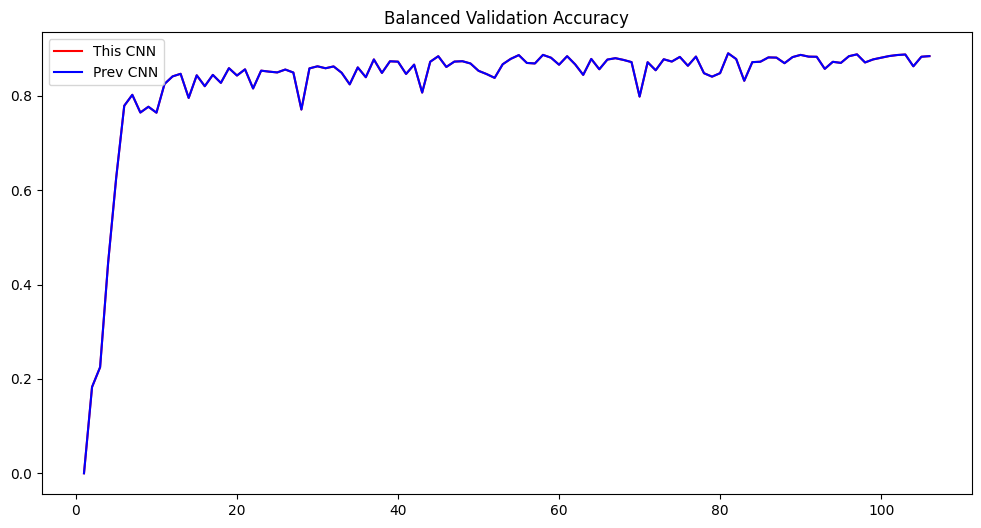

This CNN: [0.8843448658784231, 0.8830413719018301, 0.8627382814884186, 0.887773185968399, 0.886679212252299, 0.8845125834147135, 0.8809618353843689, 0.877346803744634, 0.8708886206150055, 0.88808873295784, 0.8841709891955057, 0.8699768483638763, 0.8723105986913046, 0.8573465645313263, 0.8829342623551687, 0.8832549154758453, 0.886956105629603, 0.882293164730072, 0.8693775435288748, 0.8811643620332082, 0.8816233575344086, 0.8724732200304667, 0.8715568979581197, 0.8321050703525543, 0.878127376238505, 0.8903783758481344, 0.8482339779535929, 0.8408060371875763, 0.848114679257075, 0.8833939433097839, 0.8638665278752645, 0.8826724290847778, 0.8728062510490417, 0.8776835103829702, 0.8543836176395416, 0.8714700937271118, 0.7985811233520508, 0.8716843028863271, 0.8763044476509094, 0.879965583483378, 0.8770230710506439, 0.8564554949601492, 0.8783571521441141, 0.8445713023344675, 0.8668591777483622, 0.8842006822427114, 0.8661352495352427, 0.8809781769911448, 0.8869636754194895, 0.8687830169995626,

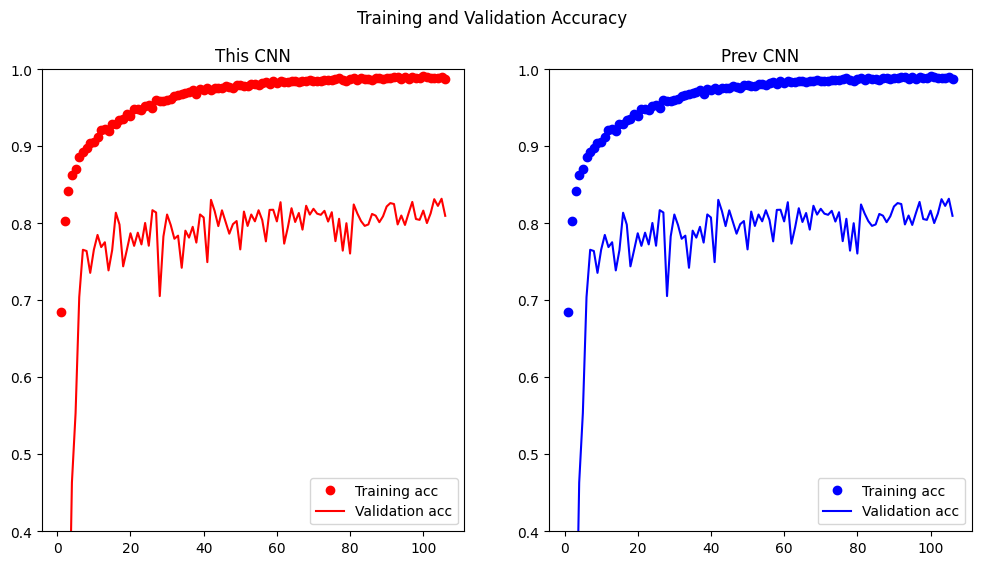

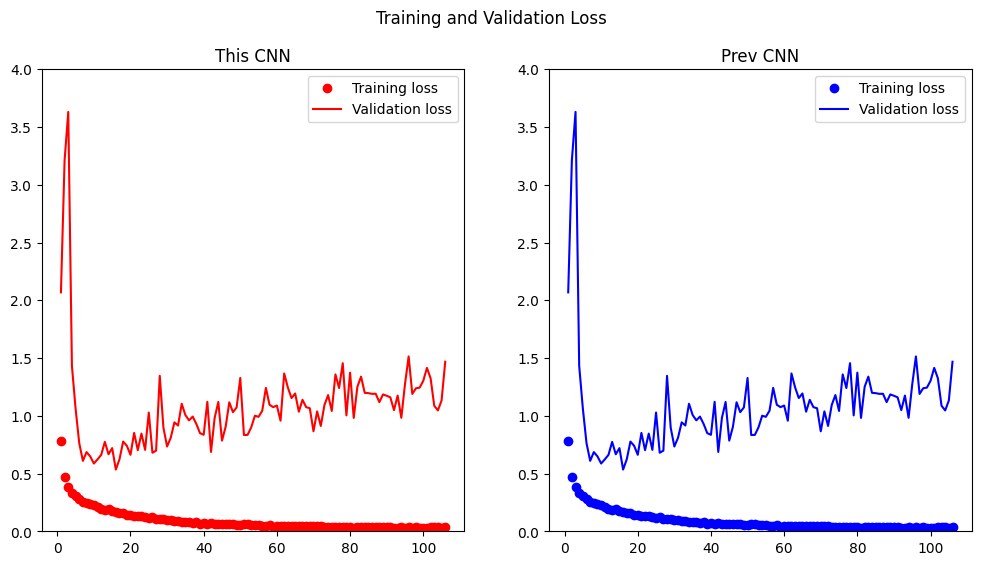

In [10]:
history_cnn = model_cnn.fit(x=X_train ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(X_val,y_val_labels) ,verbose=1,
                           callbacks=[TrainBalancedAccuracyCallback(), ValBalancedAccuracyCallback(),
                                       keras.callbacks.EarlyStopping(monitor='val_balacc', patience=25, restore_best_weights=True)])
if first_time:
    prev_history = history_cnn
    prev_model = model_cnn
    first_time = False
display_model_data(history_cnn, prev_history)
print(f'This CNN: {history_cnn.history["val_balacc"][::-1]}')
print(f'Prev CNN: {prev_history.history["val_balacc"][::-1]}')
prev_model.summary()
prev_history = history_cnn
prev_model = model_cnn

In [11]:
conf_tot = tf.math.confusion_matrix(y_val, np.argmax(model_cnn.predict(X_val), axis=1))

333/333 [==============================] - 1s 1ms/step


In [152]:
#Random Forest
X_train = np.reshape(X_train, (len(X_train), 2352))
X_val = np.reshape(X_val, (len(X_val), 2352))
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_val)
rfc_acc = balanced_accuracy_score(y_val, rfc_predict)
rfc_acc

KeyboardInterrupt: 

In [ ]:
#SVC
svc = SVC(kernel='rbf', C=1.0, probability=True)
X_train = np.reshape(X_train, (len(X_train), 2352))
svc.fit(X_train, y_train)
X_val = np.reshape(X_val, (len(X_val), 2352))

svc_acc = balanced_accuracy_score(y_val, svc.predict(X_val))
print("Balanced Validation Accuracy:", svc_acc)

Balanced Validation Accuracy: 0.7621285680850006


In [14]:
cnn_acc = max(history_cnn.history["val_balacc"])

conf_cnn_rfc = tf.math.confusion_matrix(y_val, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val, (len(X_val), 28,28,3))) + rfc_acc * rfc.predict_proba(X_val))/(cnn_acc + rfc_acc), axis=1))
print(balanced_accuracy_score(y_val, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val, (len(X_val), 28,28,3))) + rfc_acc * rfc.predict_proba(X_val))/(cnn_acc + rfc_acc), axis=1)))
conf_cnn_svc = tf.math.confusion_matrix(y_val, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val, (len(X_val), 28,28,3))) + svc_acc * svc.predict_proba(X_val))/(cnn_acc + svc_acc), axis=1))
print(balanced_accuracy_score(y_val, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val, (len(X_val), 28,28,3))) + svc_acc * svc.predict_proba(X_val))/(cnn_acc + svc_acc), axis=1)))


333/333 [==============================] - 0s 1ms/step
0.890775305550975
333/333 [==============================] - 0s 1ms/step
0.8880052032445304


In [55]:
epochs = 20
batch_size = 256
y_train_ds = [0 if label in [0, 1, 2] else 1 for label in y_train]
y_val_ds = [0 if label in [0, 1, 2] else 1 for label in y_val]
y_labels = to_categorical(y_train_ds, 2)
X_val = np.reshape(X_val, (len(X_val),28,28,3))
y_val_labels = to_categorical(y_val_ds, 2)
model_cnn = create_ds_splitter((3,3))

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 800)               0         
                                                                 
 dense_26 (Dense)            (None, 800)             

Epoch 1/20
 86/101 [========================>.....] - ETA: 0s - loss: 0.0910 - recall_0: 0.9633 - recall_1: 0.9845 - accuracy: 0.9603 train_balacc 0.9763197302818298
val_balacc 0.9785463213920593
101/101 [==============================] - 1s 6ms/step - loss: 0.0790 - recall_0: 0.9665 - recall_1: 0.9861 - accuracy: 0.9658 - val_loss: 0.0477 - val_recall_0: 1.0000 - val_recall_1: 0.9571 - val_accuracy: 0.9828 - train_balacc: 0.9763 - val_balacc: 0.9785
Epoch 2/20
 85/101 [========================>.....] - ETA: 0s - loss: 0.0042 - recall_0: 0.9990 - recall_1: 0.9992 - accuracy: 0.9991 train_balacc 0.9991450905799866
val_balacc 0.9919109046459198
101/101 [==============================] - 0s 4ms/step - loss: 0.0038 - recall_0: 0.9991 - recall_1: 0.9992 - accuracy: 0.9991 - val_loss: 0.0144 - val_recall_0: 1.0000 - val_recall_1: 0.9838 - val_accuracy: 0.9935 - train_balacc: 0.9991 - val_balacc: 0.9919
Epoch 3/20
 88/101 [=========================>....] - ETA: 0s - loss: 0.0015 - recall_0: 0

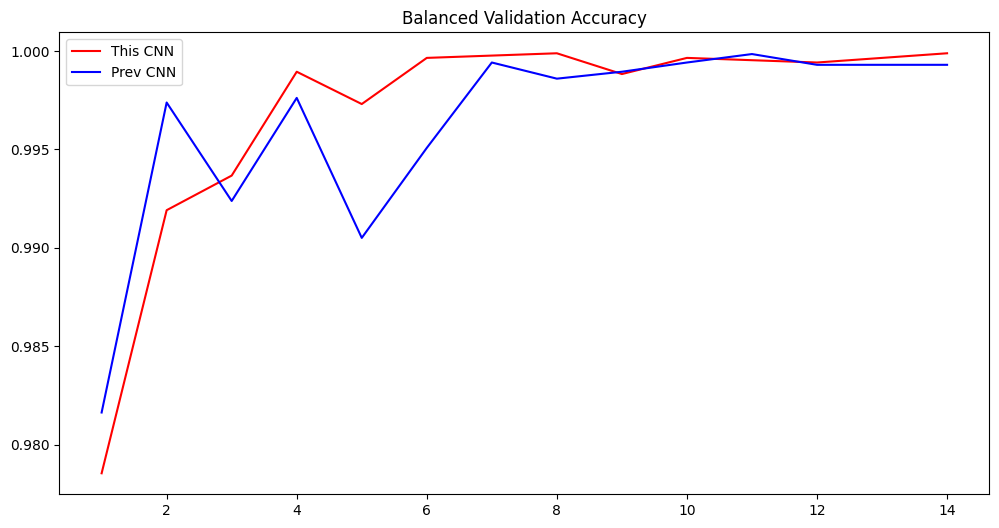

This CNN: [0.9998827576637268, 0.9996483027935028, 0.9994138479232788, 0.9995310604572296, 0.9996483027935028, 0.9988276660442352, 0.9998827576637268, 0.999765545129776, 0.9996483027935028, 0.9973036348819733, 0.9989449083805084, 0.9936693906784058, 0.9919109046459198, 0.9785463213920593]
Prev CNN: [0.9996483027935028, 0.999765545129776, 0.9930832386016846, 0.9992966055870056, 0.9992966055870056, 0.9992966055870056, 0.9998431503772736, 0.9994138479232788, 0.9989449083805084, 0.9985932111740112, 0.9994138479232788, 0.9950762093067169, 0.990504115819931, 0.9976157248020172, 0.9923798441886902, 0.9973812401294708, 0.9816331565380096]
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)   

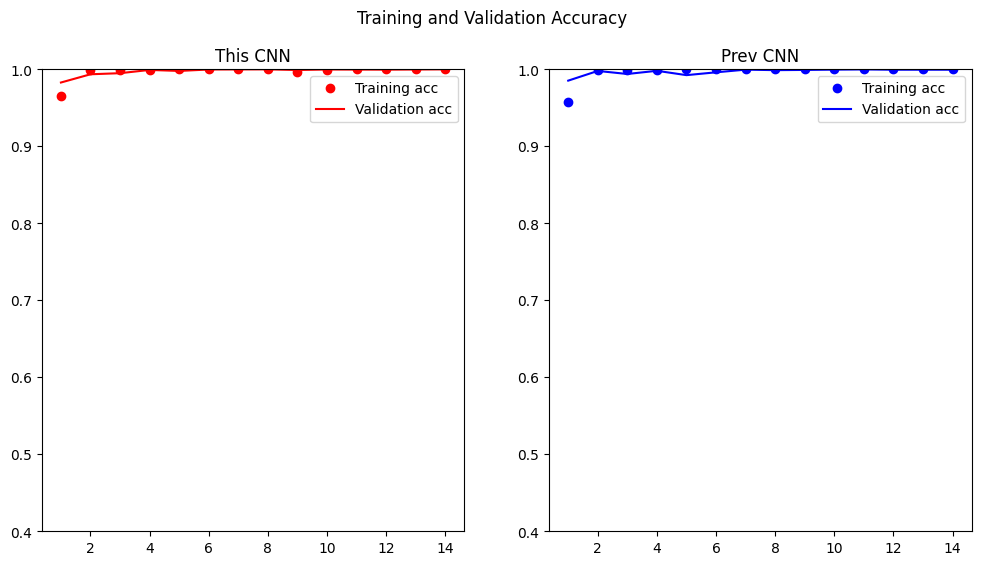

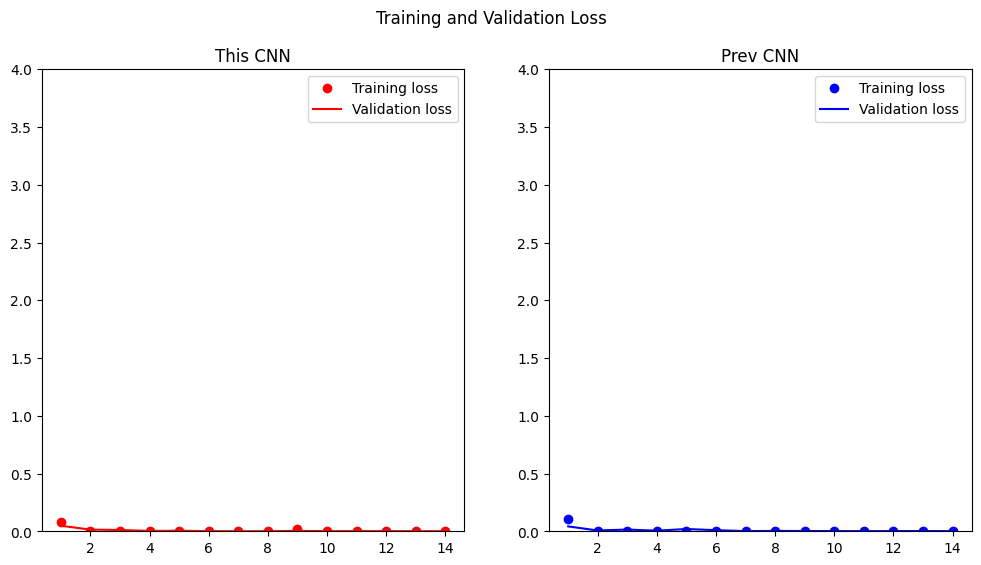

In [56]:
history_cnn = model_cnn.fit(x=X_train ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(X_val,y_val_labels) ,verbose=1,
                           callbacks=[TrainBalancedAccuracyCallback(), ValBalancedAccuracyCallback(),
                                      keras.callbacks.EarlyStopping(monitor='val_balacc', patience=6, restore_best_weights=True)])
if first_time:
    prev_history = history_cnn
    prev_model = model_cnn
    first_time = False
display_model_data(history_cnn, prev_history)
print(f'This CNN: {history_cnn.history["val_balacc"][::-1]}')
print(f'Prev CNN: {prev_history.history["val_balacc"][::-1]}')
prev_model.summary()
prev_history = history_cnn
prev_model = model_cnn

In [58]:
y_train_ds = [0 if label in [0, 1, 2] else 1 for label in y_train]
y_val_ds = [0 if label in [0, 1, 2] else 1 for label in y_val]

y_train_ds = np.array(y_train_ds)
y_val_ds = np.array(y_val_ds)

X_train_0 = X_train[np.where(y_train_ds == 0)]
X_val_0 = X_val[np.where(y_val_ds == 0)]
y_train_0 = y_train[np.where(y_train_ds == 0)]
y_val_0 = y_val[np.where(y_val_ds == 0)]

X_train_1 = X_train[np.where(y_train_ds == 1)]
X_val_1 = X_val[np.where(y_val_ds == 1)]
y_train_1 = y_train[np.where(y_train_ds == 1)]
y_val_1 = y_val[np.where(y_val_ds == 1)]

In [96]:
epochs = 300
batch_size = 256
y_labels = to_categorical(y_train_0, 3)
y_val_labels = to_categorical(y_val_0, 3)
model_cnn_0 = create_CNN_model((3,3))

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_28 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 average_pooling2d_28 (Avera  (None, 13, 13, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_49 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_72 (Conv2D)          (None, 13, 13, 64)      

Epoch 1/300
11/51 [=====>........................] - ETA: 0s - loss: 1.2141 - recall_0: 0.6608 - recall_1: 0.7281 - recall_2: 0.7811 - accuracy: 0.5753

2023-10-28 22:46:12.961661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_44/dropout_49/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


46/51 [==========================>...] - ETA: 0s - loss: 0.7537 - recall_0: 0.6325 - recall_1: 0.6704 - recall_2: 0.7818 - accuracy: 0.6951 train_balacc 0.6968128482500712
val_balacc 0.0
51/51 [==============================] - 1s 18ms/step - loss: 0.7357 - recall_0: 0.6338 - recall_1: 0.6658 - recall_2: 0.7908 - accuracy: 0.7013 - val_loss: 1.1103 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.1564 - train_balacc: 0.6968 - val_balacc: 0.0000e+00
Epoch 2/300
46/51 [==========================>...] - ETA: 0s - loss: 0.4649 - recall_0: 0.6879 - recall_1: 0.7376 - recall_2: 0.8978 - accuracy: 0.7979 train_balacc 0.7768710851669312
val_balacc 0.052777777115503945
51/51 [==============================] - 1s 13ms/step - loss: 0.4615 - recall_0: 0.6890 - recall_1: 0.7428 - recall_2: 0.8988 - accuracy: 0.7993 - val_loss: 1.1311 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_recall_2: 0.1583 - val_accuracy: 0.1936 - train_balacc: 0

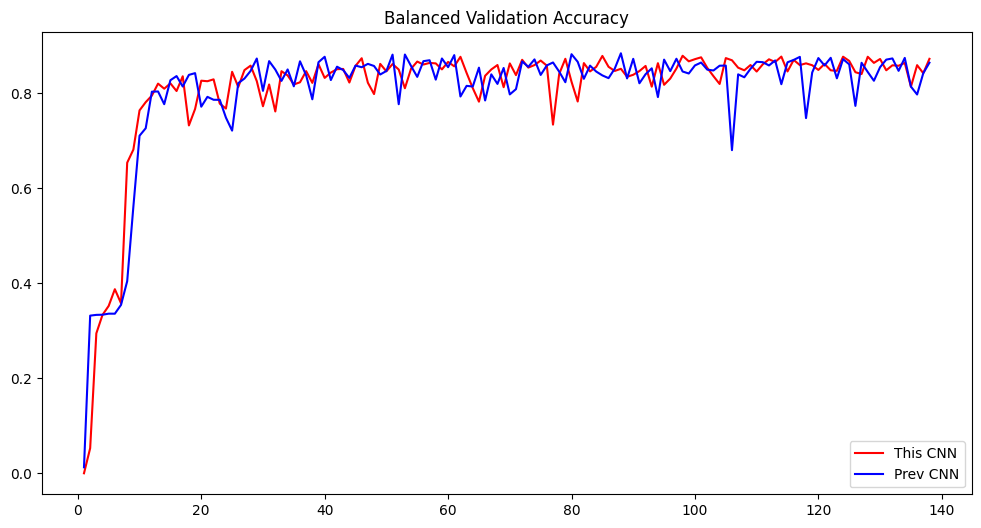

This CNN: [0.844465176264445, 0.866651177406311, 0.8265072504679362, 0.867865800857544, 0.8775800665219625, 0.8705030481020609, 0.8675563136736552, 0.877585212389628, 0.8531773885091146, 0.8334082166353861, 0.8721598188082377, 0.8419119119644165, 0.8588542739550272, 0.8135175307591757, 0.8635865052541097, 0.8575775424639384, 0.8585824569066366, 0.8480542103449503, 0.8718174894650778, 0.8636245131492615, 0.8765164812405905, 0.8401291171709696, 0.8440359234809875, 0.8677436908086141, 0.8766749501228333, 0.8468139171600342, 0.848008950551351, 0.8614336450894674, 0.8487862944602966, 0.8586918115615845, 0.8626296321551005, 0.8590108156204224, 0.8698272705078125, 0.8455749750137329, 0.8768624265988668, 0.8654371698697408, 0.8711759050687155, 0.8606939713160197, 0.8454047640164694, 0.8591015140215555, 0.8480331103006998, 0.8535076181093851, 0.8691311875979105, 0.8737027049064636, 0.8192324837048849, 0.8356902599334717, 0.8531167109807333, 0.8753348390261332, 0.8714537024497986, 0.866906285285

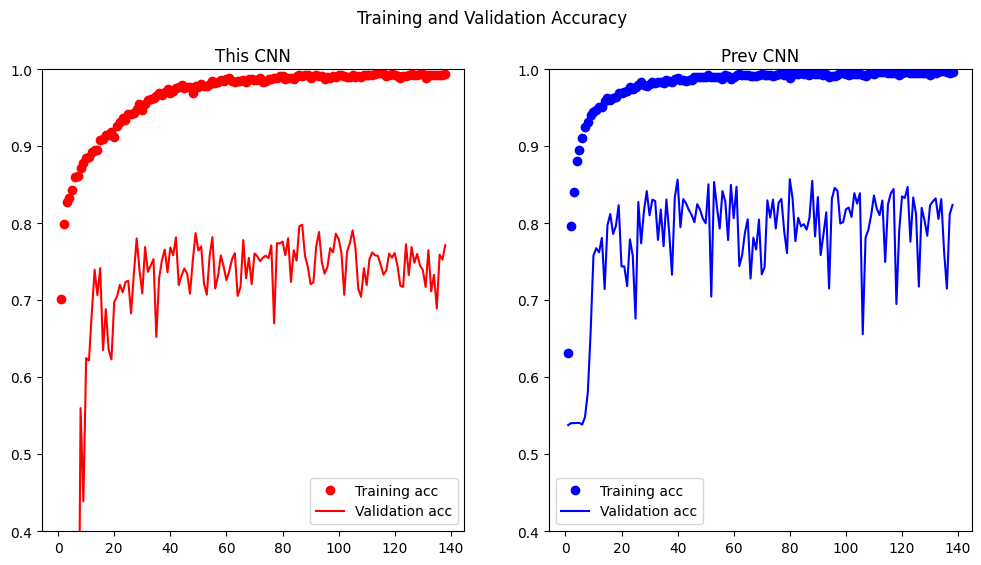

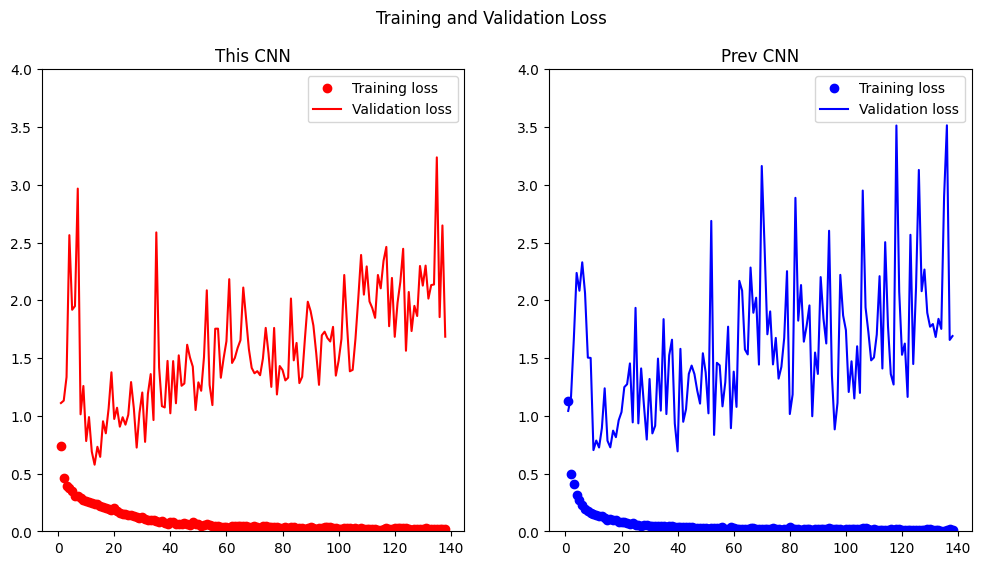

In [97]:
history_cnn = model_cnn_0.fit(x=np.reshape(X_train_0, (len(X_train_0),28,28,3)) ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(np.reshape(X_val_0, (len(X_val_0),28,28,3)),y_val_labels) ,verbose=1,
                           callbacks=[TrainBalancedAccuracyCallback(), ValBalancedAccuracyCallback(),
                                      keras.callbacks.EarlyStopping(monitor='val_balacc', patience=50, restore_best_weights=True)])
if first_time:
    prev_history = history_cnn
    prev_model = model_cnn_0
    first_time = False
display_model_data(history_cnn, prev_history)
print(f'This CNN: {history_cnn.history["val_balacc"][::-1]}')
print(f'Prev CNN: {prev_history.history["val_balacc"][::-1]}')
prev_model.summary()
prev_history = history_cnn
prev_model = model_cnn_0

In [67]:
conf_0 = tf.math.confusion_matrix(y_val_0, np.argmax(model_cnn_0.predict(np.reshape(X_val_0, (len(X_val_0),28,28,3))), axis=1))

200/200 [==============================] - 0s 1ms/step


In [34]:
X_train_0 = np.reshape(X_train_0, (len(X_train_0), 2352))
X_val_0 = np.reshape(X_val_0, (len(X_val_0), 2352))
hgc = HistGradientBoostingClassifier(loss='log_loss')
hgc.fit(X_train_0, y_train_0)
hgc_acc = balanced_accuracy_score(y_val_0, hgc.predict(X_val_0))
hgc_acc

0.810717090589233

In [35]:
#Random Forest
X_train_0 = np.reshape(X_train_0, (len(X_train_0), 2352))
X_val_0 = np.reshape(X_val_0, (len(X_val_0), 2352))
rfc = RandomForestClassifier()
rfc.fit(X_train_0, y_train_0)
rfc_acc = balanced_accuracy_score(y_val_0, rfc.predict(X_val_0))
rfc_acc

0.76593912781437

In [36]:
#SVC
X_train_0 = np.reshape(X_train_0, (len(X_train_0), 2352))
X_val_0 = np.reshape(X_val_0, (len(X_val_0), 2352))
svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train_0, y_train_0)
svc_acc = balanced_accuracy_score(y_val_0, svc.predict(X_val_0))
svc_acc

0.7689449814013937

In [37]:
cnn_acc = max(history_cnn.history["val_balacc"])
conf_cnn_hgc = tf.math.confusion_matrix(y_val_0, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + hgc_acc * hgc.predict_proba(X_val_0))/(cnn_acc + hgc_acc), axis=1))
print(balanced_accuracy_score(y_val_0, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + hgc_acc * hgc.predict_proba(X_val_0))/(cnn_acc + hgc_acc), axis=1)))
conf_cnn_rfc = tf.math.confusion_matrix(y_val_0, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + rfc_acc * rfc.predict_proba(X_val_0))/(cnn_acc + rfc_acc), axis=1))
print(balanced_accuracy_score(y_val_0, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + rfc_acc * rfc.predict_proba(X_val_0))/(cnn_acc + rfc_acc), axis=1)))
conf_cnn_svc = tf.math.confusion_matrix(y_val_0, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + svc_acc * svc.predict_proba(X_val_0))/(cnn_acc + svc_acc), axis=1))
print(balanced_accuracy_score(y_val_0, np.argmax((cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + svc_acc * svc.predict_proba(X_val_0))/(cnn_acc + svc_acc), axis=1)))
conf_cnn_svc_rfc = tf.math.confusion_matrix(y_val_0, np.argmax((rfc_acc * rfc.predict_proba(X_val_0) + cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + svc_acc * svc.predict_proba(X_val_0))/(rfc_acc + cnn_acc + svc_acc), axis=1))
print(balanced_accuracy_score(y_val_0, np.argmax((rfc_acc * rfc.predict_proba(X_val_0) + cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + svc_acc * svc.predict_proba(X_val_0))/(rfc_acc + cnn_acc + svc_acc), axis=1)))
conf_cnn_svc_hgc = tf.math.confusion_matrix(y_val_0, np.argmax((hgc_acc * hgc.predict_proba(X_val_0) + cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + svc_acc * svc.predict_proba(X_val_0))/(hgc_acc + cnn_acc + svc_acc), axis=1))
print(balanced_accuracy_score(y_val_0, np.argmax((hgc_acc * hgc.predict_proba(X_val_0) + cnn_acc * model_cnn.predict(np.reshape(X_val_0, (len(X_val_0), 28,28,3))) + svc_acc * svc.predict_proba(X_val_0))/(hgc_acc + cnn_acc + svc_acc), axis=1)))
conf_hgc_svc_rfc = tf.math.confusion_matrix(y_val_0, np.argmax((rfc_acc * rfc.predict_proba(X_val_0) + hgc_acc * hgc.predict_proba(X_val_0) + svc_acc * svc.predict_proba(X_val_0))/(rfc_acc + hgc_acc + svc_acc), axis=1))
print(balanced_accuracy_score(y_val_0, np.argmax((rfc_acc * rfc.predict_proba(X_val_0) + hgc_acc * hgc.predict_proba(X_val_0) + svc_acc * svc.predict_proba(X_val_0))/(rfc_acc + hgc_acc + svc_acc), axis=1)))

#conf_cnn_svc modelo vencedor

200/200 [==============================] - 0s 1ms/step
0.8826294717809634
200/200 [==============================] - 0s 1ms/step
0.8836822099123532
200/200 [==============================] - 0s 1ms/step
0.88437437825272
200/200 [==============================] - 0s 1ms/step
0.8732106476875946
200/200 [==============================] - 0s 1ms/step
0.8637726257834744
0.8057276959252938


In [94]:
epochs = 300
batch_size = 256
y_labels = to_categorical(y_train_1-3, 3)
y_val_labels = to_categorical(y_val_1-3, 3)
model_cnn_1 = create_CNN_model((3,3))

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_26 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_67 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 average_pooling2d_26 (Avera  (None, 13, 13, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_46 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 13, 13, 64)      

Epoch 1/300
11/51 [=====>........................] - ETA: 0s - loss: 2.7169 - recall_0: 0.4391 - recall_1: 0.2642 - recall_2: 0.3175 - accuracy: 0.3849

2023-10-28 22:44:25.214579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_43/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


46/51 [==========================>...] - ETA: 0s - loss: 1.1805 - recall_0: 0.5445 - recall_1: 0.4028 - recall_2: 0.6471 - accuracy: 0.6206 train_balacc 0.546980639298757
val_balacc 0.012581344693899155
51/51 [==============================] - 2s 17ms/step - loss: 1.1296 - recall_0: 0.5619 - recall_1: 0.4164 - recall_2: 0.6626 - accuracy: 0.6321 - val_loss: 1.0422 - val_recall_0: 0.0377 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5379 - train_balacc: 0.5470 - val_balacc: 0.0126
Epoch 2/300
46/51 [==========================>...] - ETA: 0s - loss: 0.5034 - recall_0: 0.7673 - recall_1: 0.7159 - recall_2: 0.8072 - accuracy: 0.7936 train_balacc 0.768011192480723
val_balacc 0.3317425847053528
51/51 [==============================] - 1s 13ms/step - loss: 0.4977 - recall_0: 0.7682 - recall_1: 0.7244 - recall_2: 0.8114 - accuracy: 0.7970 - val_loss: 1.1639 - val_recall_0: 0.9952 - val_recall_1: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5404 - train_bala

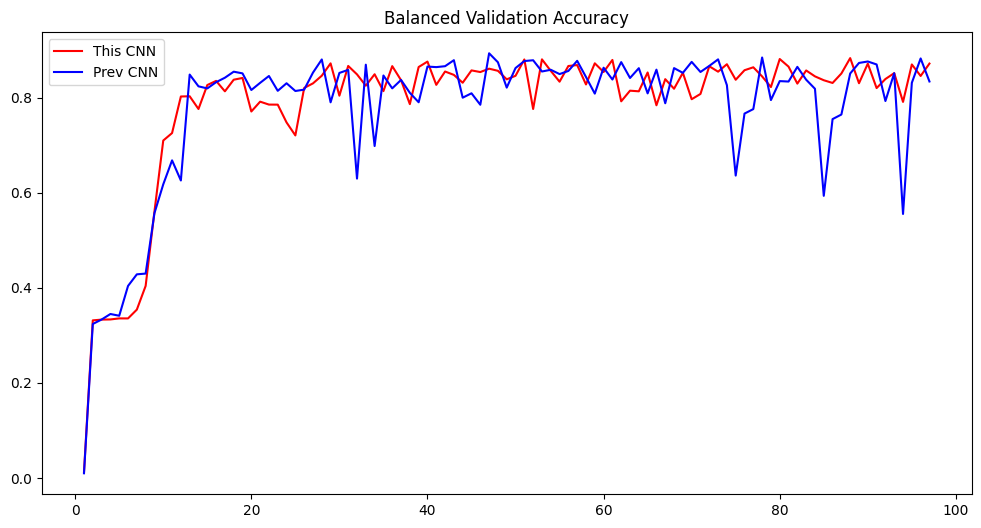

This CNN: [0.8640601833661398, 0.8419232964515686, 0.7971078554789225, 0.8136672973632812, 0.8740975459416708, 0.8468950788180033, 0.8729739586512247, 0.8704668680826823, 0.8546017607053121, 0.8260357777277628, 0.8444792032241821, 0.8638432621955872, 0.773145337899526, 0.8605383435885111, 0.8715526064236959, 0.8311709960301717, 0.8742899298667908, 0.8580858906110128, 0.8737777272860209, 0.8433910608291626, 0.7474422653516134, 0.8762770493825277, 0.8698428471883138, 0.8648990591367086, 0.8187512755393982, 0.8687355120976766, 0.8582415779431661, 0.8650907278060913, 0.8659158746401469, 0.8511238892873129, 0.8333386778831482, 0.8394891222318014, 0.6799600521723429, 0.8579509059588114, 0.8576865593592325, 0.8476395209630331, 0.8494022885958353, 0.8643176158269247, 0.8582602143287659, 0.8412766853968302, 0.8454911311467489, 0.8723373611768087, 0.8462593952814738, 0.8704859018325806, 0.7916380961736044, 0.8521869579950968, 0.8397939999898275, 0.8207288185755411, 0.872158924738566, 0.830947995

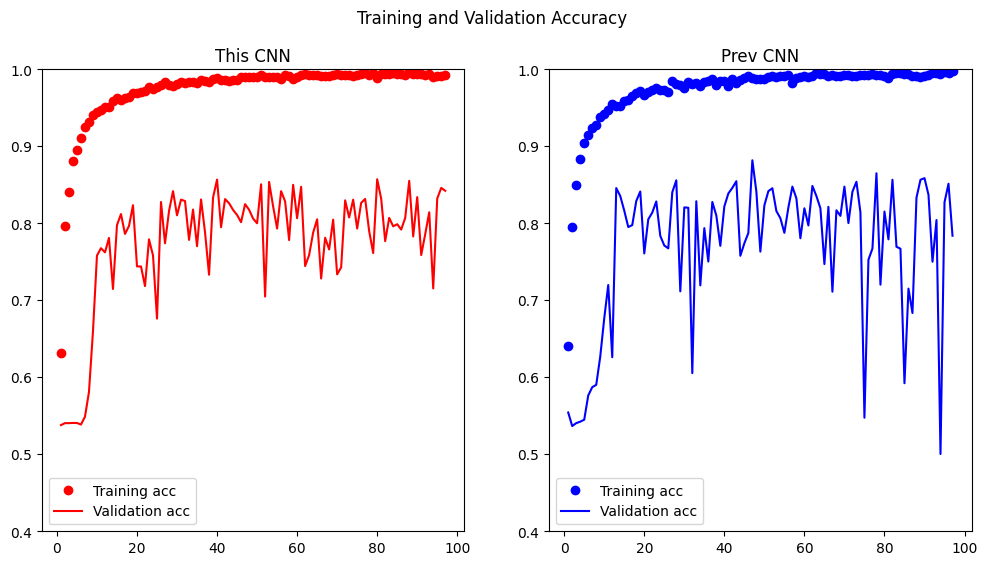

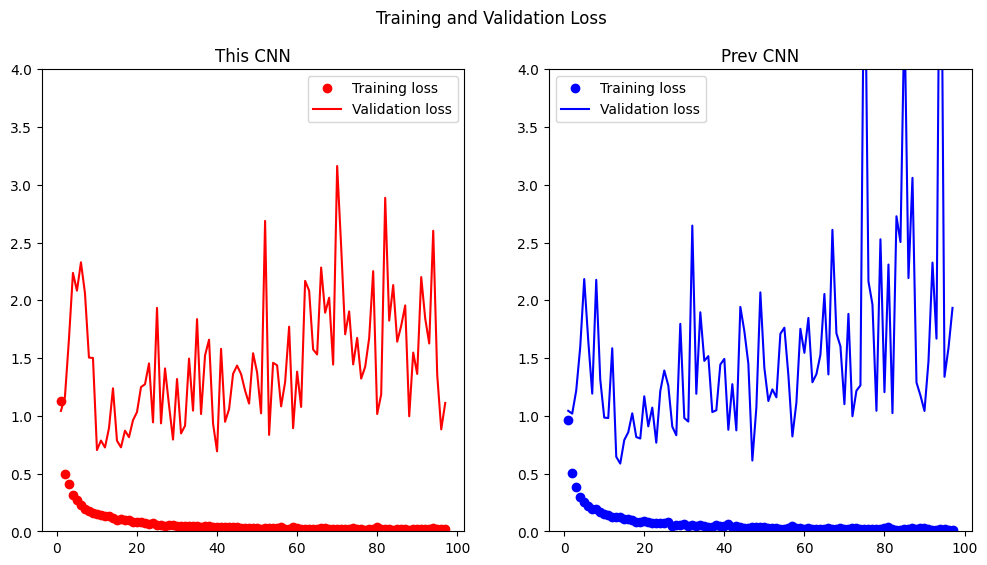

In [95]:
history_cnn = model_cnn_1.fit(x=X_train_1 ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(X_val_1,y_val_labels) ,verbose=1,
                           callbacks=[TrainBalancedAccuracyCallback(), ValBalancedAccuracyCallback(),
                                      keras.callbacks.EarlyStopping(monitor='val_balacc', patience=50, restore_best_weights=True)])
if first_time:
    prev_history = history_cnn
    prev_model = model_cnn_1
    first_time = False
display_model_data(history_cnn, prev_history)
print(f'This CNN: {history_cnn.history["val_balacc"][::-1]}')
print(f'Prev CNN: {prev_history.history["val_balacc"][::-1]}')
prev_model.summary()
prev_history = history_cnn
prev_model = model_cnn_1

In [71]:
conf_1 = tf.math.confusion_matrix(y_val_1-3, np.argmax(model_cnn_1.predict(X_val_1), axis=1))

134/134 [==============================] - 0s 2ms/step


In [149]:
y_pred = predict_with_last_model(X_val, model_cnn, model_cnn_0, model_cnn_1)

134/134 [==============================] - 0s 1ms/step
(6376,)


In [150]:
y_pred = np.array(y_pred) 
conf_final = tf.math.confusion_matrix(y_val, y_pred)
balanced_accuracy_score(y_val, y_pred)

0.8813559505874524

In [157]:
X_test = np.load('Xtest_Classification2.npy')
X_test = (X_test).astype('float32')/255.0

y_test = predict_with_last_model(X_test, model_cnn, model_cnn_0, model_cnn_1)
y_test = np.reshape(y_test, (len(y_test),1))
print(y_test.shape)
np.save('ytest_Classification2.npy',y_test)

34/34 [==============================] - 0s 1ms/step
(2658, 1)


In [ ]:
# Display training images
n = 49*3
images = X_train[n:49+n]
labels = y_train[n:49+n]
rows, cols = 7, 7
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        image = images[i*rows + j]
        ax.imshow(image, interpolation='nearest')
        ax.set_title(f"Label {labels[i*cols + j]:1.0f}")
        ax.axis('off')
plt.tight_layout()
plt.show()